# **IMDB Sentiment Classification Using LSTM (PyTorch)**

This notebook implements sentiment analysis on the IMDB movie review dataset using an LSTM model in PyTorch.
We apply techniques like tokenization, padding, early stopping, and model checkpointing.

Technologies:
PyTorch, pandas, NLTK, NumPy
Goal:
Predict if a review is Positive  or Negative

In [ ]:
!pip install tensorflow


### **Install all the required libraries**

In [ ]:
import pandas as pd
import csv
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#Import PyTorch Modules
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

# **Download the stopword dataset**

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Load and Clean the dataset**

In [ ]:
#read the dataset file
df = pd.read_csv('/content/IMDB Dataset.csv', engine='python')
#clean the dataset
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation & numbers
    text = ' '.join(w for w in text.split() if w not in stop_words)  # Remove stopwords
    return text

df['cleaned'] = df['review'].apply(clean_text)
df[['review', 'cleaned']].head()

,review,cleaned
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


# **Tokenization**

In [ ]:
#tokenize and convert to sequences
max_words = 10000  # Limit vocabulary size
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned'])

sequences = tokenizer.texts_to_sequences(df['cleaned'])


Padding

In [ ]:
#pad the sequence
maxlen = 200  # Fixed length for all reviews
padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
padded.shape


(50000, 200)

In [ ]:
#encode the label (positive->1,negative -> 0)
label_map = {'positive': 1, 'negative': 0}
labels = df['sentiment'].map(label_map).values


# **Convert data to pytorch tensors**

In [ ]:
# Convert data to pytorch tensors
input_tensor = torch.tensor(padded, dtype=torch.long)
label_tensor = torch.tensor(labels, dtype=torch.float32)

Split the dataset for training and validation

In [ ]:
#create dataset and loaders
dataset = TensorDataset(input_tensor, label_tensor)

# Split 80% train, 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


Train batches: 625, Validation batches: 157


# IMDB data is preprocessed and convert into pytorch tensor data. now lets apply the LSTM model.

LSTM model
layer:


*   embedding
*   LSTm layer

*   Dropout layer
*   fullyConnected layer

*   Actibation Function







In [ ]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_prob=0.5):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        #set the flow of layer
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        dropped = self.dropout(hidden.squeeze(0))
        out = self.fc(dropped)
        return self.sigmoid(out)


In [ ]:
# Parameters
vocab_size = 10000
embedding_dim = 128
hidden_dim = 128
output_dim = 1
dropout_prob=0.5

model = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim,dropout_prob)
#Automatically runs on GPU if available, otherwise CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion = nn.BCELoss() #it is good for binarry cclassification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # standard LR


In [ ]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    model = model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = (outputs >= 0.5).float()
            acc = (preds == labels).float().mean()

            train_loss += loss.item()
            train_acc += acc.item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc / len(train_loader))

        # Validation phase
        model.eval()
        val_loss, val_acc = 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                preds = (outputs >= 0.5).float()
                acc = (preds == labels).float().mean()

                val_loss += loss.item()
                val_acc += acc.item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accuracies[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f}, Acc: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=5
)




Epoch 1/5 | Train Loss: 0.0810, Acc: 0.9778 | Val Loss: 0.5141, Acc: 0.8635
Epoch 2/5 | Train Loss: 0.0723, Acc: 0.9804 | Val Loss: 0.5032, Acc: 0.8652
Epoch 3/5 | Train Loss: 0.0679, Acc: 0.9822 | Val Loss: 0.4909, Acc: 0.8545
Epoch 4/5 | Train Loss: 0.0704, Acc: 0.9803 | Val Loss: 0.5325, Acc: 0.8661
Epoch 5/5 | Train Loss: 0.0539, Acc: 0.9866 | Val Loss: 0.5255, Acc: 0.8640


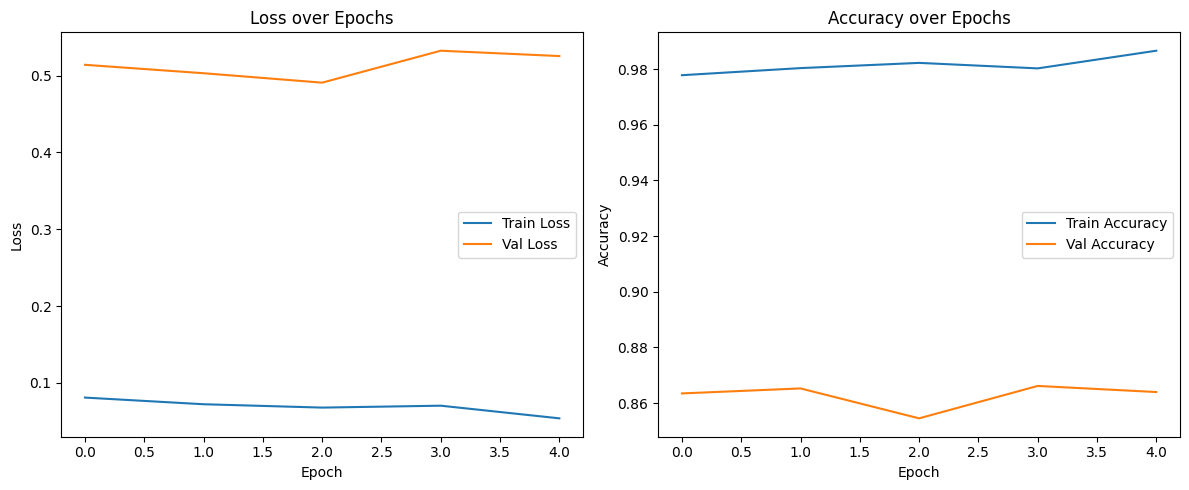

In [ ]:
# Plotting Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Now,

In [ ]:
#define a preprocessing function
def clean_input_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(w for w in text.split() if w not in stop_words)
    return text


defien a prediction function

In [ ]:
#inference
def predict_sentiment(model, tokenizer, text, maxlen=200):
    model.eval()

    # Preprocess input
    cleaned = clean_input_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded_seq = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')
    input_tensor = torch.tensor(padded_seq, dtype=torch.long).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        prob = output.item()

    # Calculate confidence and sentiment
    confidence = prob * 100 if prob >= 0.5 else (1 - prob) * 100
    sentiment = "Positive 😀" if prob >= 0.5 else "Negative 😞"

    # Output results
    print(f"\n Input Text: {text}")
    print(f" Cleaned: {cleaned}")
    print(f" Probability: {prob:.4f}")
    print(f" Predicted Sentiment: {sentiment}")
    print(f" Confidence: {confidence:.2f}%")


In [ ]:
test_text = "I really loved this movie, it was overly exaggrettted"
predict_sentiment(model, tokenizer, "in this movie the hero was too lazy")
predict_sentiment(model, tokenizer, test_text)
predict_sentiment(model, tokenizer, "This movie was incredibly emotional and beautiful.")




 Input Text: in this movie the hero was too lazy
 Cleaned: movie hero lazy
 Probability: 0.0114
 Predicted Sentiment: Negative 😞
 Confidence: 98.86%

 Input Text: I really loved this movie, it was overly exaggrettted
 Cleaned: really loved movie overly exaggrettted
 Probability: 0.9944
 Predicted Sentiment: Positive 😀
 Confidence: 99.44%

 Input Text: This movie was incredibly emotional and beautiful.
 Cleaned: movie incredibly emotional beautiful
 Probability: 0.8688
 Predicted Sentiment: Positive 😀
 Confidence: 86.88%
